In [1]:
# !pip install keras-core --upgrade
# !pip install -q keras-nlp
# !pip install seaborn

In [2]:
# !pip install transformers

# Import the Libararies

In [3]:
# !pip install pandas

In [4]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# import keras_core as keras
# import keras_nlp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
print("TensorFlow version:", tf.__version__)
# print("Keras version:", keras.__version__)
# print("KerasNLP version:", keras_nlp.__version__)

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version: 2.7.0


# Load the data


In [5]:
train_prompts = pd.read_csv('train_prompts.csv') #('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
train_essays = pd.read_csv('train_essays.csv')#('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test_essays = pd.read_csv('test_essays.csv')#('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
train_extra = pd.read_csv('train_v3_drcat_01.csv')#('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_01.csv')
train_extra_2 = pd.read_csv('train_v3_drcat_02.csv')#('/kaggle/input/daigt-v3-train-dataset/train_v3_drcat_02.csv')

# 🐝데이터 준비 (증강X)

Text(0.5, 1.0, 'Distribution of Generated Text')

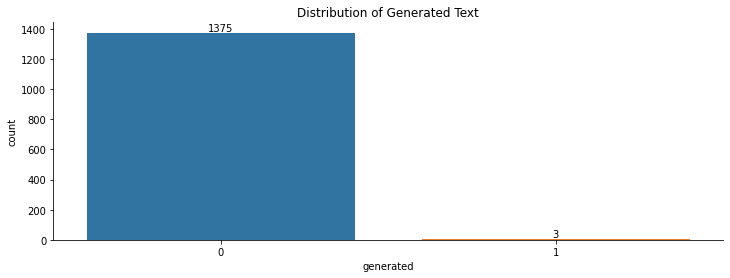

In [6]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays,
                   x="generated")

abs_values = train_essays['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [7]:
train_essays.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [8]:
train_essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [9]:
df_train_essays_final = train_essays.drop_duplicates(subset=['text'])

df_train_essays_final.reset_index(drop=True, inplace=True)

In [10]:
df_train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


Text(0.5, 1.0, 'Distribution of Generated Text')

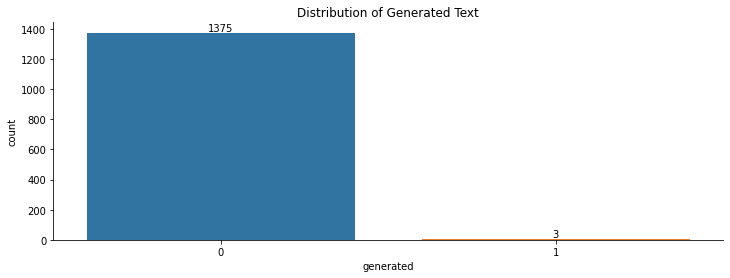

In [11]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_final,
                   x="generated")


abs_values = df_train_essays_final['generated'].value_counts(sort=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution of Generated Text")

# 🐝train_essays 길이분석(증강X)

In [12]:
df_train_essays_final['text_length'] = df_train_essays_final['text'].apply(len)

# 'generated' 항목을 기준으로 0과 1로 데이터를 나눕니다.
generated_0 = df_train_essays_final[df_train_essays_final['generated'] == 0]
generated_1 = df_train_essays_final[df_train_essays_final['generated'] == 1]

# 데이터프레임에서 'text' 항목의 문장들을 추출합니다.
sentences_0 = generated_0['text'].tolist()
sentences_1 = generated_1['text'].tolist()

# 문장들의 길이를 측정합니다.
sentence_lengths_0 = [len(sentence.split()) for sentence in sentences_0]
sentence_lengths_1 = [len(sentence.split()) for sentence in sentences_1]

# 문장들의 길이가 50 이하인 요소들의 개수 확인
count_sentences_0_below_50 = sum(1 for length in sentence_lengths_0 if length <= 50)
count_sentences_1_below_50 = sum(1 for length in sentence_lengths_1 if length <= 50)

print("Count of 'generated' 0 with text length below 50:", count_sentences_0_below_50)
print("Count of 'generated' 1 with text length below 50:", count_sentences_1_below_50)


Count of 'generated' 0 with text length below 50: 0
Count of 'generated' 1 with text length below 50: 0


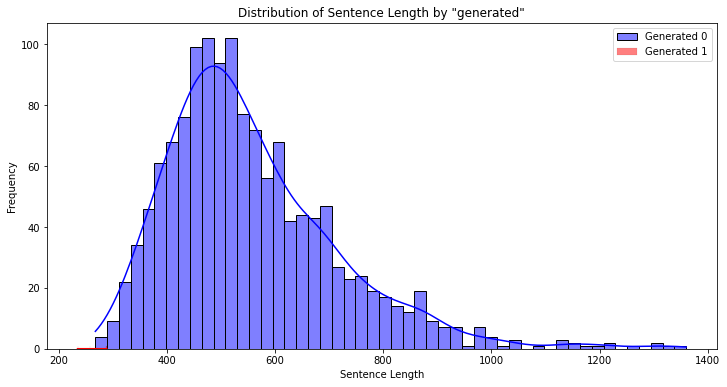

In [13]:
# 길이 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(sentence_lengths_0, bins=50, color='blue', label='Generated 0', kde=True)
sns.histplot(sentence_lengths_1, bins=50, color='red', label='Generated 1', kde=True)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Sentence Length by "generated"')
plt.show()


In [14]:
df_train_essays_final.head()

,id,prompt_id,text,generated,text_length
0,0059830c,0,Cars. Cars have been around since they became ...,0,3289
1,005db917,0,Transportation is a large necessity in most co...,0,2738
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0,4428
3,00940276,0,How often do you ride in a car? Do you drive a...,0,4013
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0,4698


In [15]:
df_train_essays_final = df_train_essays_final.drop(columns=["id", "prompt_id", "text_length"])

In [16]:
df_train_essays_final.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


# ==========증강은 대기==============
# =====================================

# 🐝 **데이터 분석 및 증강**

In [17]:
# df_train_extra=pd.concat([train_extra,train_extra_2],ignore_index=True)


In [18]:
# f, ax = plt.subplots(figsize=(12, 4))

# sns.despine()
# ax = sns.countplot(data=train_essays,
#                    x="prompt_id")

# abs_values = train_essays['prompt_id'].value_counts().values

# ax.bar_label(container=ax.containers[0], labels=abs_values)

# ax.set_title("Distribution of prompt ID")

In [19]:
# f, ax = plt.subplots(figsize=(12, 4))

# sns.despine()
# ax = sns.countplot(data=train_essays,
#                    x="generated")

# abs_values = train_essays['generated'].value_counts().values

# ax.bar_label(container=ax.containers[0], labels=abs_values)

# ax.set_title("Distribution of Generated Text")

In [20]:
# df_train_extra.rename(columns = {"label":"generated"}, inplace=True)

In [21]:
# df_train_extra.head()

In [22]:
# f, ax = plt.subplots(figsize=(12, 4))

# sns.despine()
# ax = sns.countplot(data=df_train_extra,
#                    x="generated")

# abs_values = df_train_extra['generated'].value_counts(sort=False).values

# ax.bar_label(container=ax.containers[0], labels=abs_values)

# ax.set_title("Distribution of Generated Text")

In [23]:
# df_train_essays_final = pd.concat([df_train_extra[["text", "generated"]], train_essays[["text", "generated"]]])

# df_train_essays_final.info()

In [24]:
# df_train_essays_final.isna().sum()

In [25]:
# df_train_essays_final.dropna(inplace=True)

In [26]:
# df_train_essays_final = df_train_essays_final.drop_duplicates(subset=['text'])

# df_train_essays_final.reset_index(drop=True, inplace=True)

In [27]:
# f, ax = plt.subplots(figsize=(12, 4))

# sns.despine()
# ax = sns.countplot(data=df_train_essays_final,
#                    x="generated")


# abs_values = df_train_essays_final['generated'].value_counts(sort=False).values
# ax.bar_label(container=ax.containers[0], labels=abs_values)
# ax.set_title("Distribution of Generated Text")

## 1) generated=0, student 생성 text label 데이터의 감소가 보임__ unbalance 해결 필요
## 2) 전처리된 train set의 text들이 훈련에 적절한 내용을 제대로 포함하고 있는지 확인 필요
## + GPU 메모리 부족현상을 극복

In [28]:
# df_train_essays_final['text_length'] = df_train_essays_final['text'].apply(len)

# # 'generated' 항목을 기준으로 0과 1로 데이터를 나눕니다.
# generated_0 = df_train_essays_final[df_train_essays_final['generated'] == 0]
# generated_1 = df_train_essays_final[df_train_essays_final['generated'] == 1]

# # 데이터프레임에서 'text' 항목의 문장들을 추출합니다.
# sentences_0 = generated_0['text'].tolist()
# sentences_1 = generated_1['text'].tolist()

# # 문장들의 길이를 측정합니다.
# sentence_lengths_0 = [len(sentence.split()) for sentence in sentences_0]
# sentence_lengths_1 = [len(sentence.split()) for sentence in sentences_1]

# # 문장들의 길이가 50 이하인 요소들의 개수 확인
# count_sentences_0_below_50 = sum(1 for length in sentence_lengths_0 if length <= 50)
# count_sentences_1_below_50 = sum(1 for length in sentence_lengths_1 if length <= 50)

# print("Count of 'generated' 0 with text length below 50:", count_sentences_0_below_50)
# print("Count of 'generated' 1 with text length below 50:", count_sentences_1_below_50)


In [29]:
# # 길이 분포 시각화
# plt.figure(figsize=(12, 6))
# sns.histplot(sentence_lengths_0, bins=50, color='blue', label='Generated 0', kde=True)
# sns.histplot(sentence_lengths_1, bins=50, color='red', label='Generated 1', kde=True)
# plt.xlabel('Sentence Length')
# plt.ylabel('Frequency')
# plt.legend()
# plt.title('Distribution of Sentence Length by "generated"')
# plt.show()


In [30]:
# # 'generated' 항목을 기준으로 0과 1로 데이터를 나눕니다.
# generated_0 = df_train_essays_final[df_train_essays_final['generated'] == 0]
# generated_1 = df_train_essays_final[df_train_essays_final['generated'] == 1]

# # 데이터프레임에서 'text' 항목의 문장들을 추출합니다.
# sentences_0 = generated_0['text'].tolist()
# sentences_1 = generated_1['text'].tolist()

# # 문장들의 길이를 측정합니다.
# sentence_lengths_0 = [len(sentence.split()) for sentence in sentences_0]
# sentence_lengths_1 = [len(sentence.split()) for sentence in sentences_1]

# # 50 이하인 항목들을 데이터프레임에서 제거하고 새로운 데이터프레임 생성
# generated_0 = generated_0[[(length > 50) for length in sentence_lengths_0]]
# generated_1 = generated_1[[(length > 50) for length in sentence_lengths_1]]

# # 다시 문장들의 길이를 측정
# sentence_lengths_0 = [len(sentence.split()) for sentence in generated_0['text']]
# sentence_lengths_1 = [len(sentence.split()) for sentence in generated_1['text']]

# # 문장들의 길이가 50 이하인 요소들의 개수 확인
# count_sentences_0_below_50 = len(sentences_0) - len(generated_0)
# count_sentences_1_below_50 = len(sentences_1) - len(generated_1)

# print("Count of 'generated' 0 with text length below 50:", count_sentences_0_below_50)
# print("Count of 'generated' 1 with text length below 50:", count_sentences_1_below_50)


In [31]:
# plt.figure(figsize=(12, 6))
# sns.histplot(sentence_lengths_0, bins=50, color='blue', label='Generated 0', kde=True)
# sns.histplot(sentence_lengths_1, bins=50, color='red', label='Generated 1', kde=True)
# plt.xlabel('Sentence Length')
# plt.ylabel('Frequency')
# plt.legend()
# plt.title('Distribution of Sentence Length by "generated"')
# plt.show()

In [32]:
# df_train_essays_final = pd.concat([generated_0[["text", "generated"]], generated_1[["text", "generated"]]])

# df_train_essays_final.info()

In [33]:
# # Filter out the entries where 'generated' is 1.
# generated_ones = df_train_essays_final[df_train_essays_final['generated'] == 1]

# # Sort the filtered data by the length of the 'text' column, descending.
# sorted_generated_ones = generated_ones.assign(text_length=generated_ones['text'].apply(len)).sort_values(by='text_length', ascending=True)

# # Select the top 27420 entries with the longest text.
# reduced_generated_ones = sorted_generated_ones.head(10000)



# # Filter out the entries where 'generated' is 0.
# generated_ones0 = df_train_essays_final[df_train_essays_final['generated'] == 0]

# # Sort the filtered data by the length of the 'text' column, descending.
# sorted_generated_ones0 = generated_ones0.assign(text_length=generated_ones0['text'].apply(len)).sort_values(by='text_length', ascending=True)

# # Select the top 27420 entries with the longest text.
# reduced_generated_ones0 = sorted_generated_ones0.head(10000)




# # Combine the reduced set with the entries where 'generated' is 0.
# reduced_df = pd.concat([reduced_generated_ones0, reduced_generated_ones])

# # Remove the 'text_length' column used for sorting.
# df_train_essays_final = reduced_df.drop(columns=['text_length'])

# # Check the number of entries in the reduced dataset and show the first few entries.
# df_train_essays_final.reset_index(drop=True, inplace=True)
# len(df_train_essays_final), df_train_essays_final.head()


In [34]:
# # 'generated' 항목을 기준으로 0과 1로 데이터를 나눕니다.
# generated_0 = df_train_essays_final[df_train_essays_final['generated'] == 0]
# generated_1 = df_train_essays_final[df_train_essays_final['generated'] == 1]

# # 데이터프레임에서 'text' 항목의 문장들을 추출합니다.
# sentences_0 = generated_0['text'].tolist()
# sentences_1 = generated_1['text'].tolist()

# # 문장들의 길이를 측정합니다.
# sentence_lengths_0 = [len(sentence.split()) for sentence in sentences_0]
# sentence_lengths_1 = [len(sentence.split()) for sentence in sentences_1]

# # 길이 분포 시각화
# plt.figure(figsize=(12, 6))
# sns.histplot(sentence_lengths_0, bins=50, color='blue', label='Generated 0', kde=True)
# sns.histplot(sentence_lengths_1, bins=50, color='red', label='Generated 1', kde=True)
# plt.xlabel('Sentence Length')
# plt.ylabel('Frequency')
# plt.legend()
# plt.title('Distribution of Sentence Length by "generated"')
# plt.show()


In [35]:
# f, ax = plt.subplots(figsize=(12, 4))

# sns.despine()
# ax = sns.countplot(data=df_train_essays_final,
#                    x="generated")


# abs_values = df_train_essays_final['generated'].value_counts(sort=False).values
# ax.bar_label(container=ax.containers[0], labels=abs_values)
# ax.set_title("Distribution of Generated Text")

In [36]:
# df_train_essays_final.info()

In [37]:
# df_train_essays_final.head()

# ==========오타수정 라이브러리 대기===========
# =========================================

# ❓ 오타수정 library 적용 유무 (24.01.10 : X)

In [38]:
# !pip install pyspellchecker

In [39]:
# from spellchecker import SpellChecker

# spell = SpellChecker()
# misspelled = spell.unknown(['let', 'us', 'wlak', 'on', 'the', 'groun'])

# for word in misspelled:
#     print(f'Misspelled word: {word}')
#     print(f'Suggestion: {spell.correction(word)}')


In [40]:
# !pip install textblob

In [41]:
# from textblob import TextBlob

# text = "I havv goood speling"
# blob = TextBlob(text)

# corrected_text = blob.correct()
# print(corrected_text)

In [42]:
# !pip install hunspell

In [43]:
# import hunspell

# # Hunspell 객체 생성 (사전 파일 필요)
# hun = hunspell.HunSpell('/usr/share/hunspell/en_US.dic', '/usr/share/hunspell/en_US.aff')

# # 스펠 체크
# word = "speling"
# if not hun.spell(word):
#     print(f'Misspelled word: {word}')
#     suggestions = hun.suggest(word)
#     print(f'Suggestions: {suggestions}')

# 🐝 **토큰화 진행 (WordPiece vs BPE)** 

## WordPiece

In [44]:
# max_length 파라미터 조정을 통한 성능 확인

In [45]:
problematic_data = df_train_essays_final[df_train_essays_final['text'].apply(lambda x: not isinstance(x, str))]
print(problematic_data)

Empty DataFrame
Columns: [text, generated]
Index: []


In [46]:
from transformers import RobertaTokenizer
from tqdm.auto import tqdm
import pandas as pd

# BERT 토크나이저 초기화
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# 토큰 길이 계산
token_lengths = []
for text in df_train_essays_final['text']:  # 'text_column'은 텍스트가 포함된 컬럼 이름입니다.
    tokens = tokenizer.encode(text, add_special_tokens=True)
    token_lengths.append(len(tokens))

    
df_ = df_train_essays_final.copy()
# 토큰 길이를 DataFrame에 추가
df_['text'] = token_lengths

# 길이 분포 분석
print(df_['text'].describe())

# # # 토큰 길이를 DataFrame에 추가
# df_train_essays_final['text'] = token_lengths

# # # 길이 분포 분석
# print(df_train_essays_final['text'].describe())

Token indices sequence length is longer than the specified maximum sequence length for this model (697 > 512). Running this sequence through the model will result in indexing errors


count    1378.000000
mean      661.363570
std       201.288011
min       259.000000
25%       527.000000
50%       620.500000
75%       757.750000
max      2335.000000
Name: text, dtype: float64


In [47]:

# tqdm을 사용하여 토큰화 진행 상황을 표시
input_ids = []
attention_masks = []

for text in tqdm(df_train_essays_final['text'].tolist(), desc="토큰화 진행중"):
    encoded = tokenizer.encode_plus(text, 
                                    add_special_tokens=True, 
                                    max_length=256, 
                                    padding='max_length', 
                                    truncation=True, 
                                    return_attention_mask=True, 
                                    return_tensors='np')
    input_ids.append(encoded['input_ids'][0])
    attention_masks.append(encoded['attention_mask'][0])

# 토큰화된 데이터를 pandas DataFrame으로 변환
df_encoded = pd.DataFrame({
    'input_ids': input_ids,
    'attention_mask': attention_masks
})



토큰화 진행중:   0%|          | 0/1378 [00:00<?, ?it/s]

In [48]:
df_encoded.to_csv('TF_RoBERTa_encoded_data.csv', index=False)

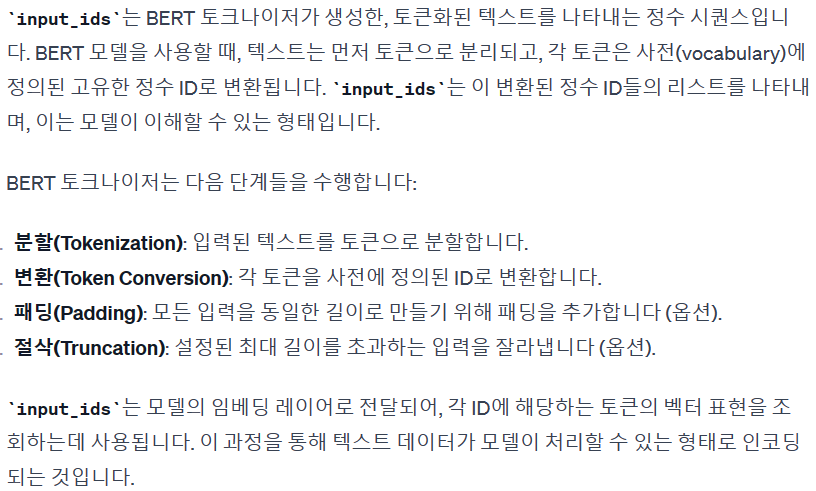

In [49]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from transformers import BertTokenizer

# # BERT 모델에 대한 기본 tokenizer를 사용합니다.
# bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # BERT의 tokenizer를 사용하여 텍스트를 토큰화하는 함수를 정의합니다.
# def bert_tokenize(text):
#     # BERT tokenizer로 토큰화하고 토큰 ID를 반환합니다.
#     return bert_tokenizer.encode(text, add_special_tokens=True)

# # TfidfVectorizer 객체를 생성하고, tokenizer로 위에서 정의한 bert_tokenize 함수를 사용합니다.
# tfidf_vectorizer = TfidfVectorizer(tokenizer=bert_tokenize, ngram_range=(1, 2))

# # 트레이닝 데이터에 대해 TF-IDF 벡터화를 수행합니다.
# X_train_tfidf = tfidf_vectorizer.fit_transform(df_train_essays_final['text'])

# # 테스트 데이터에 대해 TF-IDF 벡터화를 수행합니다.
# X_test_tfidf = tfidf_vectorizer.transform(test_essays['text'])

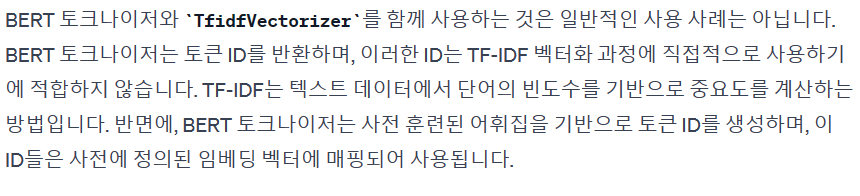

===============================================

## BPE (일단스킵)

In [50]:
# test_essays.text.values

In [51]:
# LOWERCASE = False
# VOCAB_SIZE = 30522

In [52]:
# import sys
# import gc

# import pandas as pd
# from sklearn.model_selection import StratifiedKFold
# import numpy as np
# from sklearn.metrics import roc_auc_score
# import numpy as np

# from sklearn.feature_extraction.text import TfidfVectorizer

# from tokenizers import (
#     decoders,
#     models,
#     normalizers,
#     pre_tokenizers,
#     processors,
#     trainers,
#     Tokenizer,
# )

# from datasets import Dataset
# from tqdm.auto import tqdm
# from transformers import PreTrainedTokenizerFast

# from sklearn.linear_model import SGDClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.ensemble import VotingClassifier

In [53]:
# # Creating Byte-Pair Encoding tokenizer
# # 어휘집에 없는 단어는 UNK 토큰화
# raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))


# # 소문자변환 및 유니코드 문자 정규화, 초기 문자열 byte 수준 분해
# raw_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
# raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()


# # train set에 맞는 특수 토크나이징 설정 및 훈련
# # 파라미터, 어휘집크기 30522__일단 지정
# # 
# special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
# trainer = trainers.BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=special_tokens)



# # df를 huggingface 데이터셋으로 준비, 1000개 단위씩 반복처리
# dataset = Dataset.from_pandas(test_essays[['text']])

# def train_corp_iter():
#     """
#     A generator function for iterating over a dataset in chunks.
#     """    
#     for i in range(0, len(dataset), 1000):
#         yield dataset[i : i + 1000]["text"]

        
        
# # BPE 토크나이저 훈련 진행코드, 특수 토큰도 함께 부여
# raw_tokenizer.train_from_iterator(train_corp_iter(), trainer=trainer)

# tokenizer = PreTrainedTokenizerFast(
#     tokenizer_object=raw_tokenizer,
#     unk_token="[UNK]",
#     pad_token="[PAD]",
#     cls_token="[CLS]",
#     sep_token="[SEP]",
#     mask_token="[MASK]",
# )


# # 토큰화 진행, tqdm으로 진행도 시각화

# tokenized_texts_test = []

# # Tokenize test set with new tokenizer
# for text in tqdm(test_essays['text'].tolist()):
#     tokenized_texts_test.append(tokenizer.tokenize(text))


# # Tokenize train set
# tokenized_texts_train = []

# for text in tqdm(df_train_essays_final['text'].tolist()):
#     tokenized_texts_train.append(tokenizer.tokenize(text))

## BERT 토크나이저 가 아닌
## BPE 토크나이저를 코드에 적용한 이유

###  (wordpiece(BERT기반)와 BPE(GPT기반) 성능 비교)

In [54]:
# tokenized_texts_test[1]

In [55]:
# def dummy(text):
#     """
#     A dummy function to use as tokenizer for TfidfVectorizer. It returns the text as it is since we already tokenized it.
#     """
#     return text

In [56]:
# # Fitting TfidfVectoizer on test set

# vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer = 'word',
#     tokenizer = dummy,
#     preprocessor = dummy,
#     token_pattern = None, strip_accents='unicode'
#                             )

# vectorizer.fit(tokenized_texts_test)

# # Getting vocab
# vocab = vectorizer.vocabulary_

# print(vocab)


# # Here we fit our vectorizer on train set but this time we use vocabulary from test fit.
# vectorizer = TfidfVectorizer(ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
#                             analyzer = 'word',
#                             tokenizer = dummy,
#                             preprocessor = dummy,
#                             token_pattern = None, strip_accents='unicode'
#                             )

# tf_train = vectorizer.fit_transform(tokenized_texts_train)
# tf_test = vectorizer.transform(tokenized_texts_test)

# del vectorizer
# gc.collect()

In [57]:
# y_train = df_train_essays_final['generated'].values

In [58]:
# tf_train

In [59]:
# tf_train.shape

In [60]:
# tf_test.shape

In [61]:
# pd.DataFrame(tf_train).head

In [62]:
# dense_tf_train = tf_train.todense()
# df_tf_train = pd.DataFrame(dense_tf_train)
# df_tf_train.describe()

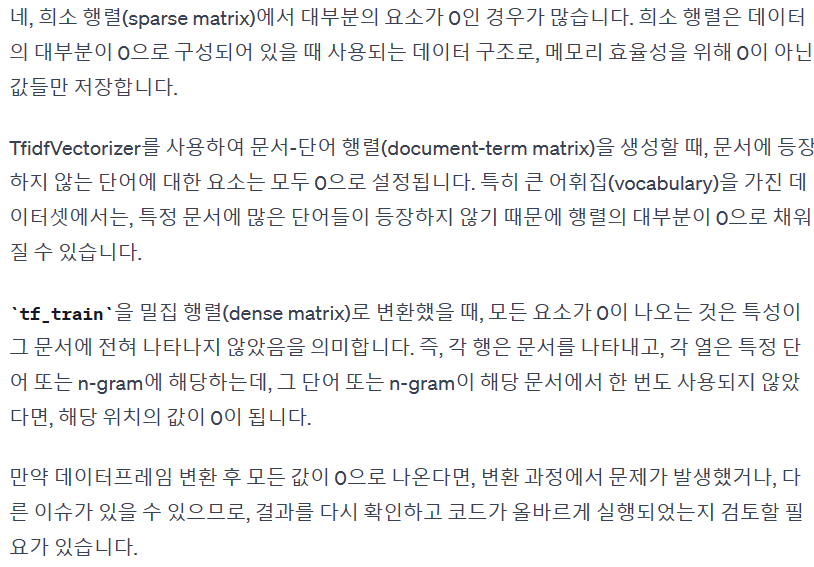

==============================================

# 🐝 **모델학습 진행**

# 🐝 RoBERTa 코드 적용

In [63]:
# import tensorflow as tf
# from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
# from sklearn.model_selection import train_test_split

# # RoBERTa 토크나이저와 모델 초기화
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
# model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

# # 텍스트 데이터 토큰화
# encoded_data = tokenizer(df_train_essays_final['text'].tolist(), 
#                          padding=True, 
#                          truncation=True, 
#                          max_length=128, 
#                          return_tensors='tf')

# input_ids = encoded_data['input_ids']
# attention_masks = encoded_data['attention_mask']

# # 레이블 준비 (여기서는 이진 분류를 가정)
# labels = tf.convert_to_tensor(df_train_essays_final['label'].values)

# # 학습 및 검증 데이터셋 분리
# train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
# train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1)

# # 데이터셋 준비
# train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_masks, train_labels)).shuffle(100).batch(32)
# validation_dataset = tf.data.Dataset.from_tensor_slices((validation_inputs, validation_masks, validation_labels)).batch(32)

# # 모델 컴파일
# optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# # 모델 학습
# model.fit(train_dataset, epochs=3, validation_data=validation_dataset)


In [64]:
import pandas as pd

df_encoded = pd.read_csv('TF_RoBERTa_encoded_data.csv')
print(df_encoded.columns)
print()
df_encoded.head()

Index(['input_ids', 'attention_mask'], dtype='object')



,input_ids,attention_mask
0,[ 0 347 2726 4 17714 33 57 1...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
1,[ 0 19163 41067 16 10 739 17331 ...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
2,[ 0 113 12580 18 657 7226 19 ...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
3,[ 0 6179 747 109 47 3068 11 ...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...
4,[ 0 347 2726 32 10 4613 631 ...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...


In [65]:
# 첫 번째 행의 'input_ids'와 'attention_mask' 열의 데이터 출력
first_row_input_ids = df_encoded['input_ids'].iloc[0]
first_row_attention_mask = df_encoded['attention_mask'].iloc[0]

first_row_input_ids, first_row_attention_mask

('[    0   347  2726     4 17714    33    57   198   187    51  1059  3395\n    11     5 23137    29     6    77  4858  2493  1412     8  1490     5\n    78  7192   565     4 17714    33   702    10   538   774    11    84\n   358   183  1074   187   172     4   125   122     6    82    32  1158\n     7   864   114 11361   512  9453    74    28    10   205   631     4\n   598   162     6 11361     5   304     9  1677   429    28    10   205\n   631     7   109     4 50118 50118  1121   101   948     9    42     6\n  1566     6    22  1121  1859  4052 13157     6  3126 32091   374  6830\n 17714    60    30  4690 32194   982     6   141 27596    32     5   784\n  3796 10188     9 13574     6   147  1692  1380  1232    31  1169  7137\n    50  1568  3805     7   146    49  1611     4 12511   224   141    42\n    16    10  1307 28968  8913     7   595  1170     7  1888 11832  1123\n  5035    31  7886 30131     4 32763  1677    32  2149    13   316   135\n     9 11832  1123  5035    11  1005

In [66]:
# 문자열을 정수 리스트로 변환하는 함수
def convert_string_to_int_list(string):
    try:
        # 줄바꿈, 대괄호 제거 및 쉼표로 분리
        cleaned_string = string.replace('\n', '').replace('[', '').replace(']', '')
        int_list = [int(i) for i in cleaned_string.split() if i.isdigit()]
        return int_list
    except:
        return []  # 변환에 실패한 경우 빈 리스트 반환

# 데이터프레임의 'input_ids' 열 변환
df_encoded['input_ids'] = df_encoded['input_ids'].apply(convert_string_to_int_list)

# 예시 출력
print(df_encoded.head())

                                           input_ids  \
0  [0, 347, 2726, 4, 17714, 33, 57, 198, 187, 51,...   
1  [0, 19163, 41067, 16, 10, 739, 17331, 11, 144,...   
2  [0, 113, 12580, 18, 657, 7226, 19, 24, 18, 173...   
3  [0, 6179, 747, 109, 47, 3068, 11, 10, 512, 116...   
4  [0, 347, 2726, 32, 10, 4613, 631, 4, 252, 32, ...   

                                      attention_mask  
0  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...  
1  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...  
2  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...  
3  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...  
4  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...  


In [67]:
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split

model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

2024-01-11 09:36:50.827924: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 09:36:51.616018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7492 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:ce:00.0, compute capability: 8.0
2024-01-11 09:36:52.706529: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRoberta

In [68]:
# input_ids = tf.convert_to_tensor(df_encoded['input_ids'].values)
# attention_masks = tf.convert_to_tensor(df_encoded['attention_mask'].values)
# labels = tf.convert_to_tensor(df_train_essays_final['generated'].values, dtype=tf.int32)
# # 레이블 데이터

In [69]:
# 데이터프레임에서 필요한 열만 선택
df_encoded = df_encoded[['input_ids', 'attention_mask']]

# 'generated' 열은 레이블로 사용할 것이므로 따로 선택
labels = df_train_essays_final['generated'].values


In [80]:
print("df_encoded shape:", df_encoded.shape)
print("labels shape:", labels.shape)
print("labels shape:", labels)

df_encoded shape: (1378, 2)
labels shape: (1378,)
labels shape: [0 0 0 ... 0 0 0]


In [82]:
# 학습 및 검증 데이터셋 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(df_encoded, labels, random_state=2018, test_size=0.2)

# 데이터셋 준비
# train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs.to_dict('list'), train_labels)).shuffle(100).batch(32)
# validation_dataset = tf.data.Dataset.from_tensor_slices((validation_inputs.to_dict('list'), validation_labels)).batch(32)
# 데이터셋 준비
# train_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": train_inputs['input_ids'], "attention_mask": train_inputs['attention_mask']}, train_labels)).shuffle(100).batch(32)
# validation_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": validation_inputs['input_ids'], "attention_mask": validation_inputs['attention_mask']}, validation_labels)).batch(32)

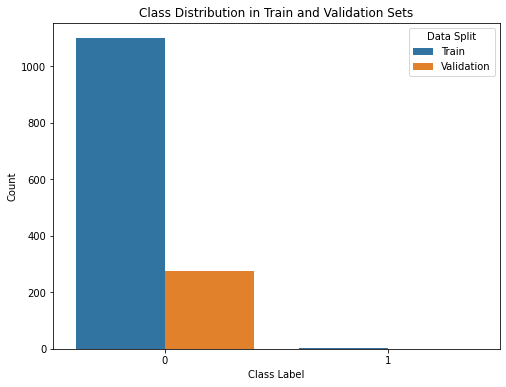

Number of data points with 'generated' label equal to 1 in Train set: 1100
Number of data points with 'generated' label equal to 1 in Validation set: 275
Number of data points with 'generated' label equal to 1 in Train set: 2
Number of data points with 'generated' label equal to 1 in Validation set: 1


In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# 클래스 분포 확인을 위한 데이터프레임 생성
train_df = pd.DataFrame({"Data Split": ["Train"] * len(train_labels), "Labels": train_labels})
validation_df = pd.DataFrame({"Data Split": ["Validation"] * len(validation_labels), "Labels": validation_labels})
combined_df = pd.concat([train_df, validation_df])

# 카운트 플롯 그리기
plt.figure(figsize=(8, 6))
sns.countplot(data=combined_df, x="Labels", hue="Data Split")
plt.title("Class Distribution in Train and Validation Sets")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.legend(title="Data Split")
plt.show()


# Train set에서 0의 개수 세기
train_generated_1_count = train_df[train_df["Labels"] == 0].shape[0]
print("Number of data points with 'generated' label equal to 1 in Train set:", train_generated_1_count)

# Validation set에서 0의 개수 세기
validation_generated_1_count = validation_df[validation_df["Labels"] == 0].shape[0]
print("Number of data points with 'generated' label equal to 1 in Validation set:", validation_generated_1_count)

# Train set에서 1의 개수 세기
train_generated_1_count = train_df[train_df["Labels"] == 1].shape[0]
print("Number of data points with 'generated' label equal to 1 in Train set:", train_generated_1_count)

# Validation set에서 1의 개수 세기
validation_generated_1_count = validation_df[validation_df["Labels"] == 1].shape[0]
print("Number of data points with 'generated' label equal to 1 in Validation set:", validation_generated_1_count)


In [87]:
# 데이터셋 준비
train_inputs = {
    "input_ids": np.array(train_inputs["input_ids"].to_list()),
    "attention_mask": np.array(train_inputs["attention_mask"].to_list())
}
train_labels = np.array(train_labels)

validation_inputs = {
    "input_ids": np.array(validation_inputs["input_ids"].to_list()),
    "attention_mask": np.array(validation_inputs["attention_mask"].to_list())
}
validation_labels = np.array(validation_labels)

print("train_inputs shape:", train_inputs["input_ids"].shape)
print("validation_inputs shape:", validation_inputs["input_ids"].shape)
print("train_labels shape:", train_labels.shape)
print("validation_labels shape:", validation_labels.shape)

train_inputs shape: (1102, 256)
validation_inputs shape: (276, 256)
train_labels shape: (1102,)
validation_labels shape: (276,)


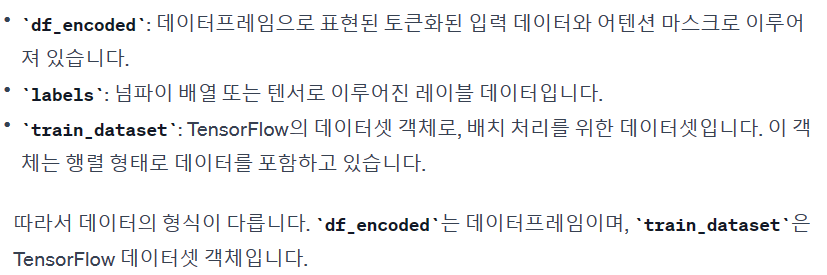

In [88]:
# 모델 컴파일
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [89]:
# 문자열을 정수 리스트로 변환하는 함수
def convert_string_to_int_array(string_array):
    int_arrays = []
    for string in string_array:
        # 문자열을 정수 리스트로 변환
        int_list = [int(i) for i in string.split() if i.isdigit()]
        int_arrays.append(int_list)
    return np.array(int_arrays, dtype=int)

# 'attention_mask'의 문자열을 정수 배열로 변환
train_inputs['attention_mask'] = convert_string_to_int_array(train_inputs['attention_mask'])
validation_inputs['attention_mask'] = convert_string_to_int_array(validation_inputs['attention_mask'])

# 변환 후 데이터 타입 재확인
print("After conversion - train_inputs[attention_mask] type:", train_inputs['attention_mask'].dtype)
print("After conversion - validation_inputs[attention_mask] type:", validation_inputs['attention_mask'].dtype)


After conversion - train_inputs[attention_mask] type: int64
After conversion - validation_inputs[attention_mask] type: int64


In [90]:
# 입력 데이터 형상 확인
print("train_inputs[input_ids] shape:", train_inputs['input_ids'].shape)
print("train_inputs[attention_mask] shape:", train_inputs['attention_mask'].shape)
print("validation_inputs[input_ids] shape:", validation_inputs['input_ids'].shape)
print("validation_inputs[attention_mask] shape:", validation_inputs['attention_mask'].shape)

# 필요한 경우 패딩 또는 트리밍 수행
# 예시: train_inputs['input_ids'] = pad_or_trim(train_inputs['input_ids'], desired_length)

# 모델 학습을 다시 시도


train_inputs[input_ids] shape: (1102, 256)
train_inputs[attention_mask] shape: (1102, 254)
validation_inputs[input_ids] shape: (276, 256)
validation_inputs[attention_mask] shape: (276, 254)


In [91]:
# attention_mask에 패딩 추가
train_inputs['attention_mask'] = np.pad(train_inputs['attention_mask'], 
                                        ((0, 0), (0, 2)),  # (데이터 시작부터 끝까지, 2개 패딩 추가)
                                        mode='constant',
                                        constant_values=0)

validation_inputs['attention_mask'] = np.pad(validation_inputs['attention_mask'],
                                             ((0, 0), (0, 2)),
                                             mode='constant',
                                             constant_values=0)

# 변환 후 데이터 형상 재확인
print("After padding - train_inputs[attention_mask] shape:", train_inputs['attention_mask'].shape)
print("After padding - validation_inputs[attention_mask] shape:", validation_inputs['attention_mask'].shape)


After padding - train_inputs[attention_mask] shape: (1102, 256)
After padding - validation_inputs[attention_mask] shape: (276, 256)


In [96]:
# 배치 크기를 줄임
batch_size = 16  # 기존 배치 크기보다 작게 설정

# 모델 학습을 다시 시도
history = model.fit(
    train_inputs,
    train_labels,
    epochs=5,
    batch_size=batch_size,  # 배치 크기 지정
    validation_data=(validation_inputs, validation_labels)
)

Epoch 1/5
69/69 [==============================] - 47s 685ms/step - loss: 3.6830e-04 - accuracy: 1.0000 - val_loss: 6.8848e-04 - val_accuracy: 1.0000
Epoch 2/5
69/69 [==============================] - 47s 687ms/step - loss: 3.2543e-04 - accuracy: 1.0000 - val_loss: 1.3698e-04 - val_accuracy: 1.0000
Epoch 3/5
69/69 [==============================] - 47s 688ms/step - loss: 1.6363e-04 - accuracy: 1.0000 - val_loss: 1.0338e-04 - val_accuracy: 1.0000
Epoch 4/5
69/69 [==============================] - 47s 687ms/step - loss: 1.3119e-04 - accuracy: 1.0000 - val_loss: 8.5648e-05 - val_accuracy: 1.0000
Epoch 5/5
69/69 [==============================] - 47s 688ms/step - loss: 1.0941e-04 - accuracy: 1.0000 - val_loss: 7.2098e-05 - val_accuracy: 1.0000


In [93]:
# # model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# model.train()      #torch 환경에서 진행

# for epoch in range(epochs):  # epochs는 원하는 에포크 수
#     for batch in dataloader:
#         batch = tuple(t.to('cuda') for t in batch)  # device는 'cuda'나 'cpu'
#         b_input_ids, b_input_mask, b_labels = batch

#         # 그래디언트 초기화
#         optimizer.zero_grad()

#         # 순전파
#         outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

#         # 손실값 계산
#         loss = outputs.loss

#         # 역전파
#         loss.backward()

#         # 가중치 업데이트
#         optimizer.step()


# 기본 데이터로 먼저 매트릭뽑기

# 논리에 집중할 것

# 정규식을 활용할 수 있을까

# 🐝 RWKV 모델 적용

# 🐝 RAG 모듈 적용

# 🐝 text 데이터 증강기법 __ unbalance 해소

# 🐝 난독화 대처방법 고찰
https://www.kaggle.com/competitions/llm-detect-ai-generated-text/discussion/461292
### 그 중 난독화, 노이즈 대처법 하나
https://www.kaggle.com/code/sjorslockhorst/authentigpt-trial-w-roberta!

# 👿 연습장

In [ ]:
# from transformers import RobertaTokenizer

# # BERT 토크나이저 초기화
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# # 텍스트 데이터 토큰화
# # `return_tensors='np'`를 사용하여 NumPy 배열로 반환 받습니다.
# encoded_inputs = tokenizer(df_train_essays_final['text'].tolist(), padding=True, truncation=True, return_tensors='np')

# # 토큰화된 데이터를 pandas DataFrame으로 변환
# df_encoded = pd.DataFrame({
#     'input_ids': encoded_inputs['input_ids'].tolist(),
#     'attention_mask': encoded_inputs['attention_mask'].tolist()
# })

# # DataFrame을 생성한 후, .describe()로 요약 통계를 확인할 수 있습니다.
# df_describe = df_encoded.describe()

# # 요약 통계 출력
# print(df_describe)

In [ ]:
# # We choose 512 because it's the limit of DistilBert
# SEQ_LENGTH = 512

# # Use a shorter sequence length.
# preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
#     "distil_bert_base_en_uncased",
#     sequence_length=SEQ_LENGTH,
# )

# # Pretrained classifier.
# classifier = keras_nlp.models.DistilBertClassifier.from_preset(
#     "distil_bert_base_en_uncased",
#     num_classes=2,
#     activation=None,
#     preprocessor=preprocessor,
# )

# # Re-compile (e.g., with a new learning rate)
# classifier.compile(
#     loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     optimizer=keras.optimizers.Adam(5e-4),
#     metrics=[
#         keras.metrics.SparseCategoricalAccuracy()
#    ]
# )
    

# # Access backbone programmatically (e.g., to change `trainable`).
# classifier.backbone.trainable = False


# classifier.summary()

In [ ]:
# Split the dataset into train and test sets
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(df_train_essays_final["text"],
                                                    df_train_essays_final["generated"],
                                                    test_size=0.30,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp,
                                                  y_temp,
                                                  test_size=0.20,
                                                  random_state=42)


In [ ]:
# Fit
classifier.fit(x=X_train, 
               y=y_train,
               validation_data=(X_test, y_test),
               epochs=2,
               batch_size=64
              )

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Human","AI"],
        cmap=plt.cm.Blues
    )
    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))
    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

In [ ]:
y_pred_test = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
displayConfusionMatrix(y_test, y_pred_test,  "Testing")

In [ ]:
y_pred_val = classifier.predict(X_val)

In [ ]:
displayConfusionMatrix(y_val, y_pred_val,  "validation")